<a href="https://colab.research.google.com/github/ybii22/Machine-Learning/blob/main/UTS/Klasifikasi_Model_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold, mutual_info_classif, chi2, f_classif
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler


In [2]:
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/My Drive/KlasifikasiUTS.csv')
df.head()

Mounted at /content/drive


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
# Remove duplicate rows
df_cleaned = df.drop_duplicates()

# Re-check shape after cleaning
cleaning_summary = {
    "Original Rows": df.shape[0],
    "Cleaned Rows": df_cleaned.shape[0],
    "Duplicates Removed": df.shape[0] - df_cleaned.shape[0]
}

df_cleaned.head(), cleaning_summary

(   Time        V1        V2        V3        V4        V5        V6        V7  \
 0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
 1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
 2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
 3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
 4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   
 
          V8        V9  ...       V21       V22       V23       V24       V25  \
 0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
 1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
 2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
 3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
 4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   
 
         V26      

In [4]:
# Pisahkan fitur dan target
X = df.drop(columns=['Class'])
y = df['Class']

# Hapus constant & quasi-constant features
vt = VarianceThreshold(threshold=0.01)
X_vt = vt.fit_transform(X)
X = X[X.columns[vt.get_support()]]

# Hapus fitur yang sangat berkorelasi (> 0.9)
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop_corr = [col for col in upper.columns if any(upper[col] > 0.9)]
X = X.drop(columns=to_drop_corr)

# **Feature Selection**

In [5]:
# Subset data 10.000 baris secara acak
X_sample = X.sample(n=10000, random_state=42)
y_sample = y.loc[X_sample.index]

# Hitung skor mutual information
mi_scores = mutual_info_classif(X_sample, y_sample, random_state=42)
mi_series = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

# Tampilkan 15 fitur dengan informasi paling tinggi
print("Top 15 Fitur berdasarkan Mutual Information:")
print(mi_series.head(15))

# Pilih fitur terbaik dari dataset penuh
top_features = mi_series.head(15).index
X_selected = X[top_features]

Top 15 Fitur berdasarkan Mutual Information:
V17    0.007444
V14    0.006448
V10    0.005640
V16    0.004805
V11    0.003976
V12    0.003865
V18    0.003132
V7     0.002430
V21    0.002104
V4     0.001999
V3     0.001845
V1     0.001592
V28    0.001182
V27    0.000991
V9     0.000977
dtype: float64


# **Feature Engineering**

In [6]:
# Feature Engineering: Standardisasi
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)
X_scaled_df = pd.DataFrame(X_scaled, columns=top_features)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.2, stratify=y, random_state=42)

# Preview hasil akhir
print(X_scaled_df.head())

        V17       V14       V10       V16       V11       V12       V18  \
0  0.244863 -0.324610  0.083386 -0.536833 -0.540407 -0.618296  0.030770   
1 -0.135170 -0.149982 -0.153350  0.529434  1.580003  1.066089 -0.218763   
2  1.306868 -0.173114  0.190700 -3.298235  0.611830  0.066137 -0.144790   
3 -0.805445 -0.300360 -0.050468 -1.209296 -0.221892  0.178371  2.345305   
4 -0.279081 -1.168034  0.691625 -0.515205 -0.806147  0.538627 -0.045569   

         V7       V21        V4        V3        V1       V28       V27  \
0  0.193679 -0.024923  0.973366  1.672773 -0.694242 -0.063781  0.330892   
1 -0.063700 -0.307377  0.316523  0.109797  0.608496  0.044608 -0.022256   
2  0.639776  0.337632  0.268231  1.169468 -0.693500 -0.181021 -0.137137   
3  0.192071 -0.147443 -0.609727  1.182516 -0.493325  0.186189  0.155396   
4  0.479302 -0.012839  0.284655  1.021412 -0.591330  0.651816  0.543620   

         V9  
0  0.331128  
1 -0.232494  
2 -1.378675  
3 -1.262503  
4  0.744326  


# **Model SVM**

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     56864
           1       0.19      0.78      0.31        98

    accuracy                           0.99     56962
   macro avg       0.60      0.88      0.65     56962
weighted avg       1.00      0.99      1.00     56962

Confusion Matrix:
 [[56545   319]
 [   22    76]]
ROC AUC Score: 0.9685192309900887


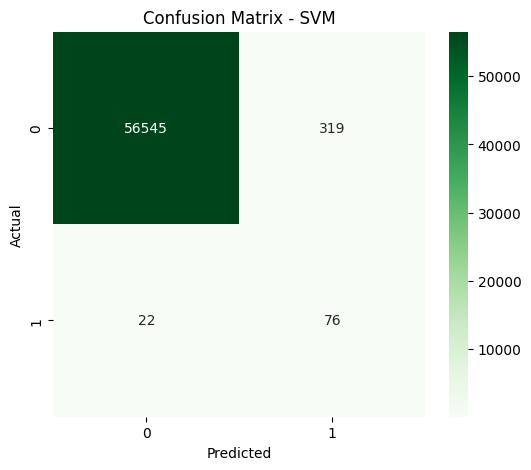

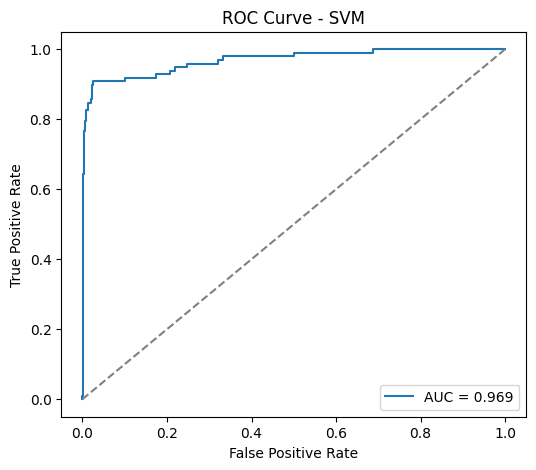

In [7]:
# Inisialisasi dan pelatihan model SVM
svm_model = SVC(probability=True, class_weight='balanced', kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_model.fit(X_train, y_train)

# Prediksi
y_pred_svm = svm_model.predict(X_test)
y_prob_svm = svm_model.predict_proba(X_test)[:, 1]

# Evaluasi
print("Classification Report:\n", classification_report(y_test, y_pred_svm))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob_svm))

# Confusion Matrix Plot
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - SVM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_prob_svm)
plt.figure(figsize=(6,5))
plt.plot(fpr_svm, tpr_svm, label=f"AUC = {roc_auc_score(y_test, y_prob_svm):.3f}")
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.title("ROC Curve - SVM")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

SVM (Support Vector Machine) adalah model klasifikasi yang bekerja dengan mencari hyperplane terbaik untuk memisahkan kelas secara maksimal.

**Precision** (fraud)	0.19	: Dari seluruh prediksi fraud, hanya 19% benar-benar fraud → banyak false positive.

**Recall** (fraud)	0.78	: Dari semua kasus fraud sebenarnya, 78% berhasil terdeteksi. Ini cukup tinggi.

**F1-Score** (fraud)	0.31 : Rata-rata harmonis antara precision & recall. Rendah karena precision buruk.

**Support**	98: Total kasus fraud di data uji.

Recall merupakan matrik terbaik disini karena menunjukkan kemampuan menampang fraud dengan baik.

Model SVM ini tidak lebih baik dari pada model bagging sebelumnya. SVM cocok jika ingin menangkap sebanyak mungkin fraud dan tidak masalah dengan false alarm, tapi kurang ideal jika butuh akurasi pada deteksi fraud.